In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
import numpy as np

import seaborn as sns

pl.seed_everything(42)

Global seed set to 42


42

In [2]:
x = torch.linspace(-5, 5, 1000)

class LinBin(pl.LightningModule):
    def __init__(self, init_weight, init_bias, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )
        
        # initialize parameters
        nn.init.constant_(self.model[0].weight, self.hparams.init_weight)
        nn.init.constant_(self.model[0].bias, self.hparams.init_bias)
        
    def forward(self, x):
        return dist.Bernoulli(self.model(x).squeeze())
    
model = LinBin(1, 0)
y_dist = model(x.unsqueeze(1))

<AxesSubplot:>

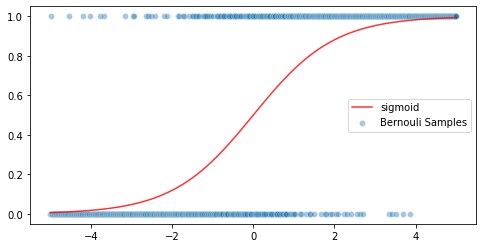

In [3]:
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(x=x, y=y_dist.sample(), alpha=0.4, label='Bernouli Samples')
sns.lineplot(x=x, y=(1/(1+torch.exp(-x))), color='red', alpha=0.8, label='sigmoid')

In [4]:
# create a constant input for this model
x = torch.tensor([[0.0]])
y_dist = model(x)
y_dist

Bernoulli(probs: 0.5)

In [5]:
# take samples from the Bernoulli
for _ in range(5):
    print(y_dist.sample())

tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)


### Probabilistic model with wrong weights
Given the samples, will try to learn the weights of the NN that produced these samples.
Here the NN outputs a probility distribution. 

In [42]:
def nll(y, y_dist):
    return -y_dist.log_prob(y)

class LinBern2(pl.LightningModule):
    def __init__(self, init_weight, init_bias, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )
        
        # initialize parameters
        nn.init.constant_(self.model[0].weight, self.hparams.init_weight)
        nn.init.constant_(self.model[0].bias, self.hparams.init_bias)
        
        # store weights
        self.trainable_weights = []
        self.trainable_biases = []
        self.losses = []
        
    def forward(self, x):
        out = self.model(x)
#         print(f'out.shape - {out.shape}')
        return dist.Bernoulli(out.squeeze())
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_dist = self.forward(x)
        loss = nll(y, y_dist).sum()
        self.trainable_weights.append(self.model[0].weight.item())
        self.trainable_biases.append(self.model[0].bias.item())
        self.losses.append(loss)
        self.log('loss', loss)
        return loss
    
    def train_dataloader(self):
        return dl
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    
# create y by sampling from the output prob dist of model with right weights
x = torch.linspace(-5, 5, 1000)
y = model(x.unsqueeze(1)).sample()
ds = TensorDataset(x.unsqueeze(1), y)
dl = DataLoader(ds, batch_size=500)

model2 = LinBern2(init_weight=2,init_bias=2, learning_rate=0.01)
trainer = pl.Trainer(max_epochs=300)
trainer.fit(model2) 

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/achinta/miniconda3/envs/cudf15/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2     
-------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/home/achinta/miniconda3/envs/cudf15/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

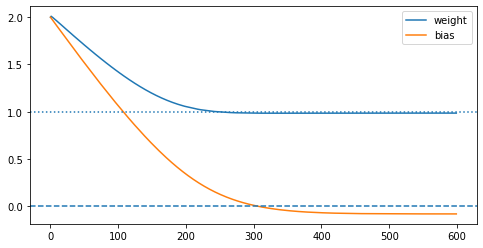

In [43]:
fig, ax = plt.subplots(figsize=(8,4))
num_points = model2.trainable_weights
sns.lineplot(x=range(len(num_points)), y=model2.trainable_weights, label='weight', ax=ax)
sns.lineplot(x=range(len(num_points)), y=model2.trainable_biases, label='bias', ax=ax)
ax.axhline(0.0, ls='--')
ax.axhline(1.0, ls=':')

In [8]:
[o for o in model2.parameters()]

[Parameter containing:
 tensor([[0.9566]], requires_grad=True),
 Parameter containing:
 tensor([-0.0096], requires_grad=True)]

### Probabilistic Linear Regression with user defined and learned variance
Data is created using 
$$y_i = x_i + 0.3\epsilon_i$$
where $\epsilon_i \sim N(0,1)$

<AxesSubplot:>

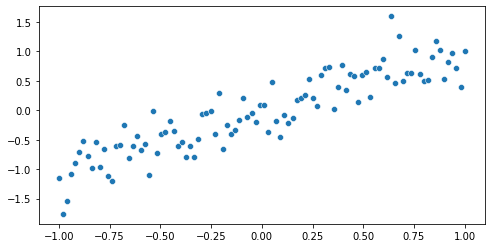

In [9]:
num_points = 100
x_train = torch.linspace(-1, 1, num_points)
y_train = x_train + 0.3*torch.randn(num_points)

fig, axs = plt.subplots(figsize=(8,4))
sns.scatterplot(x=x_train.numpy(), y=y_train.numpy())

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/achinta/miniconda3/envs/cudf15/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | lin       | Linear  | 2     
1 | loss_func | MSELoss | 0     
--------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/home/achinta/miniconda3/envs/cudf15/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.

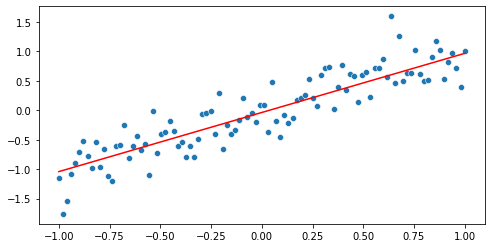

1

In [10]:
ds = TensorDataset(x_train.unsqueeze(1), y_train)
dl = DataLoader(ds, batch_size=30, num_workers=2)

def plot_preds(x_train, y_train, model):
    fig, ax = plt.subplots(figsize=(8,4))
    y_pred = lr_model.forward(x_train.unsqueeze(1))
    sns.scatterplot(x=x_train.numpy(), y=y_train.numpy(), ax=ax)
    sns.lineplot(x=x_train.numpy(), y=y_pred.squeeze().detach().numpy(), ax=ax, color='red')
    plt.show()
#     plt.pause(0.05)
    

class LR(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.lin = nn.Linear(1, 1)
        self.loss_func = nn.MSELoss()
        
    def forward(self, x):
        return self.lin(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss_func(yhat.squeeze(1), y) 
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    
    def train_dataloader(self):
        return dl
    
class PlotDataCallback(pl.callbacks.Callback):
    def on_train_end(self, trainer, pl_module):
        plot_preds(x_train, y_train, pl_module)
        
        

trainer = pl.Trainer(max_epochs=300, callbacks=[PlotDataCallback()])
lr_model = LR(learning_rate=0.01)
trainer.fit(lr_model)

### Probabilistic Logistic Regression

In [47]:

# create data
num_points = 1000
x_train = torch.linspace(-1, 1, num_points)
y_train = x_train + 0.2*torch.randn(num_points)

# dataloaders
ds = TensorDataset(x_train.unsqueeze(1), y_train)
dl = DataLoader(ds, batch_size=100, num_workers=2)


class ProbLR(pl.LightningModule):
    def __init__(self, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        # create two outputs, mean and std of the normal distribution
        self.lin = nn.Linear(1,2)
        print(f'linear initialized with weights {self.lin.weight} and bias {self.lin.bias}')
        self.losses = []
            
    def forward(self, x):
        out = self.lin(x)
        norm = dist.Normal(loc=out[:,0], scale=out[:,1])
#         print(f'Norm.event_shape - {norm.event_shape}. Norm batch_shape - {norm.batch_shape}')
        return norm
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_dist = self.forward(x)
        loss = nll(y, y_dist).mean()
        return loss
        
    def train_dataloader(self):
        return dl
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    
# class LoggingCallback(nn)

# create model and trainer
trainer = pl.Trainer(max_epochs=100)
prob_lr_model = ProbLR(learning_rate=0.01)

# initial output distribution
y_init_dist = prob_lr_model.eval()(x_train.unsqueeze(1))

# find learning rate
# lr_finder = trainer.tuner.lr_find(prob_lr_model)
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # set the learning rate
# new_lr = lr_finder.suggestion()
# print(f'new learning rate - {new_lr}')
# model.hparams.lr = new_lr

trainer.fit(prob_lr_model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | lin  | Linear | 4     
--------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)


linear initialized with weights Parameter containing:
tensor([[0.9601],
        [0.0455]], requires_grad=True) and bias Parameter containing:
tensor([-0.7496, -0.3904], requires_grad=True)


1

### 

x_train.shape: torch.Size([1000]) y_dist: Normal(loc: torch.Size([1000]), scale: torch.Size([1000])) y_pred.shape: torch.Size([1000])


<AxesSubplot:>

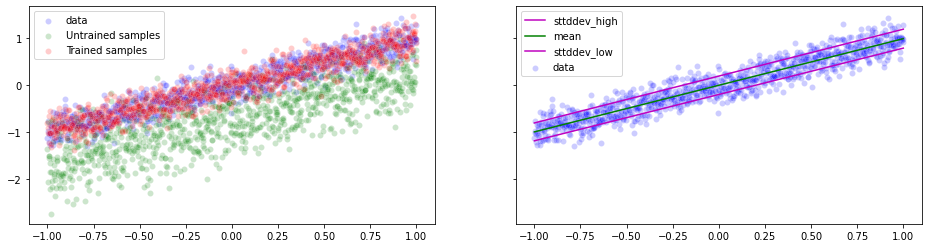

In [49]:
y_dist = prob_lr_model(x_train.unsqueeze(1))
y_pred = y_dist.sample().detach()
y_mean = y_dist.mean.detach().numpy()
y_std = y_dist.stddev.detach().numpy()
print(f'x_train.shape: {x_train.shape} y_dist: {y_dist} y_pred.shape: {y_pred.shape}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4), sharey=True)
sns.scatterplot(x=x_train.numpy(), y=y_train.numpy(), ax=ax1, color='blue', label='data', alpha=0.2)
sns.scatterplot(x=x_train.numpy(), y=y_init_dist.sample(), ax=ax1, color='green', label='Untrained samples', alpha=0.2)
sns.scatterplot(x=x_train.numpy(), y=y_pred.numpy(), ax=ax1, color='red', label='Trained samples', alpha=0.2)
sns.scatterplot(x=x_train.numpy(), y=y_train.numpy(), ax=ax2, color='blue', label='data', alpha=0.2)
sns.lineplot(x=x_train.numpy(), y=(y_mean + y_std), ax=ax2, color='m', label='sttddev_high')
sns.lineplot(x=x_train.numpy(), y=(y_mean), ax=ax2, color='green', label='mean')
sns.lineplot(x=x_train.numpy(), y=(y_mean - y_std), ax=ax2, color='m', label='sttddev_low')

### Probabilistic Linear Regression with non linear learned mean and variance
Lets change the data to non-linear
$$
y_i = x_i^3 + 0.1*(2 + x_i)\epsilon_i
$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed

<AxesSubplot:>

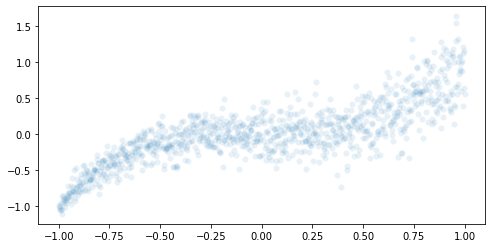

In [55]:
# Create and plot 10,000 data points
x_train = torch.linspace(-1, 1, 1000)
y_train = torch.pow(x_train, 3) + 0.1*(2 + x_train)*torch.randn(1000)

fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(x=x_train.numpy(), y=y_train.numpy(), alpha=0.1)

In [68]:
norm = dist.Normal(loc=torch.randn(8), scale=torch.randn(8))
print(f'batch shape - {norm.batch_shape}')
dist.Independent()

batch shape - torch.Size([8])


In [62]:
class Cubic(pl.LightningModule):
    def __init__(self, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Linear(1, 8, ),
            nn.Sigmoid(),
            nn.Linear(8, 16,)
        )
        
    def forward(self, x):
        out = self.model(x)
        y_dist = dist.Normal(loc=out[:,0:8], scale=out[:,8:16])
        return y_dist
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_dist = self.forward(x)
        loss = nll(y, y_dist).mean()
        return loss
    
    def train_dataloader(self):
        return dl
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    
ds = TensorDataset(x_train.unsqueeze(1), y_train)
dl = DataLoader(ds, batch_size=100)

cubic_model = Cubic(learning_rate=0.01)
y_init_dist = cubic_model.eval()(x_train.unsqueeze(1))

trainer = pl.Trainer(max_epochs=200)
trainer.fit(cubic_model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/achinta/miniconda3/envs/cudf15/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 34    
-------------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/home/achinta/miniconda3/envs/cudf15/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

x_train.shape: torch.Size([1000]) y_dist: Normal(loc: torch.Size([1000]), scale: torch.Size([1000])) y_pred.shape: torch.Size([1000])


<AxesSubplot:>

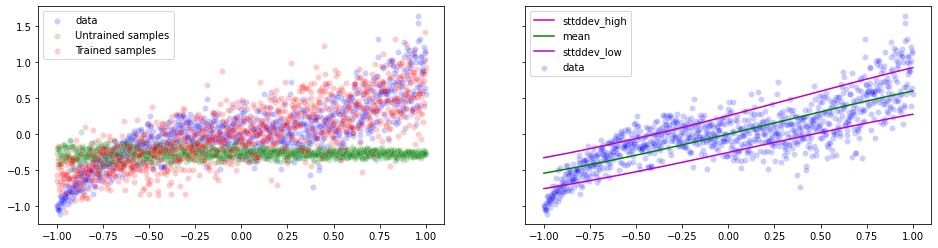

In [63]:
y_dist = cubic_model(x_train.unsqueeze(1))
y_pred = y_dist.sample().detach()
y_mean = y_dist.mean.detach().numpy()
y_std = y_dist.stddev.detach().numpy()
print(f'x_train.shape: {x_train.shape} y_dist: {y_dist} y_pred.shape: {y_pred.shape}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4), sharey=True)
sns.scatterplot(x=x_train.numpy(), y=y_train.numpy(), ax=ax1, color='blue', label='data', alpha=0.2)
sns.scatterplot(x=x_train.numpy(), y=y_init_dist.sample(), ax=ax1, color='green', label='Untrained samples', alpha=0.2)
sns.scatterplot(x=x_train.numpy(), y=y_pred.numpy(), ax=ax1, color='red', label='Trained samples', alpha=0.2)
sns.scatterplot(x=x_train.numpy(), y=y_train.numpy(), ax=ax2, color='blue', label='data', alpha=0.2)
sns.lineplot(x=x_train.numpy(), y=(y_mean + y_std), ax=ax2, color='m', label='sttddev_high')
sns.lineplot(x=x_train.numpy(), y=(y_mean), ax=ax2, color='green', label='mean')
sns.lineplot(x=x_train.numpy(), y=(y_mean - y_std), ax=ax2, color='m', label='sttddev_low')